In [1]:
import pandas as pd
import numpy as np

In [2]:

with open("./data/causal_inference.txt", 'r') as f:
    text = f.readlines()

In [3]:
res = []
for t in text:
    res.append(list(map(int, t.strip('\n').split(" ")[:-1]))) # 最後空文字が入っている。
#     print(t.strip('\n').split(" ")[:-1])

# コロンビア大学で用いられているサンプルデータセット
http://www.cs.columbia.edu/~jebara/6998/hw2.pdf

- the 1st column is the chosen arm
- the 2nd column is binary reward 
- the remaining columns are the context features.

In [4]:
ds = pd.DataFrame(res)
ds.columns = ["arm", "reward"] + [f"feat_{i}" for i in range(100)]

In [5]:
X = ds.loc[:, "feat_0":].values
y = ds.loc[:, "reward"].values
arms = ds.loc[:,"arm"].values

### Reward の分布はこんな感じ

In [6]:
ds.groupby("arm").mean()["reward"].plot(kind="bar")
print((ds.groupby("arm").mean()["reward"]*100).iloc[0])

2.0588235294117645


In [7]:
#action = 3
# reward = 1 if y==2 else 0
class ContextualArms(object):
    def __init__(self,
                 n_action,
                 max_n_sim, 
                 X, y=None,
                 arms=None,
                 n_features=4,
                ):
        self.X = X
        self.y = y
        self.arms = arms
        self.n_action = n_action
        self.max_n_sim = max_n_sim
        self.t_count = 0
        self.current_samples_idxs = None
        self.history_idx = []
    def __len__(self):
        return self.n_action
    def __getitem__(self, index):
        return self.X[index, :], self.y[index]
        pass
    def reset(self):
        self.t_count = 0

    def draw(self):
        assert self.X is not None  and self.y is not None
        res = {}
        retrieve_indices = []
        for a in range(1, self.n_action+1):
            arm_a_idx_list = list(np.where(self.arms == a)[0])
            idx_a = random.sample(arm_a_idx_list, 1)
            retrieve_indices.append(idx_a)
        self.candidates_idx = retrieve_indices
        res = self.X[retrieve_indices, :]
        
        self.current_samples_idxs = list(itertools.chain.from_iterable(retrieve_indices))
        return res
    def get_reward(self, index):
        """
        rewardが0,1の値をとる確率変数でわかりずらかったため、試しにdetermined valued rewardを与える。
        """
        self.history_idx.append(self.candidates_idx[index])
        return (ds.groupby("arm").mean()["reward"]*100).iloc[index]

#         return self.y[self.current_samples_idxs[index]]

In [8]:
import itertools, os
os.listdir()


['.DS_Store',
 'Bandit_LinUCB.ipynb',
 'README.md',
 'nim.py',
 '.gitignore',
 'agent.py',
 '.ipynb_checkpoints',
 '.git',
 'data']

In [9]:
Arms = ContextualArms(n_action=10, max_n_sim=100, X=X, y=y,arms=arms, n_features=X.shape[1])

In [10]:
import random

Arms.draw().shape


(10, 1, 100)

In [11]:
Arms.get_reward(1)

26.782077393075355

In [12]:
list(Arms.current_samples_idxs)

[8629, 1924, 169, 4011, 6957, 5697, 3290, 655, 6023, 4168]

In [13]:
A = ds.loc[:, "feat_0":].values

In [14]:
class LinUCB(object):
    
    def __init__(self, sigma=1, sigma_0=1):
        
        pass

## LinUCB方策(アルゴリズム 7.1)

うーんよくわからんかった。
A_aはそれぞれの選択肢aにおける特徴量の分散行列で、p_atはpredicted valueのXX%信頼区間の上限値？かな？()
$\sqrt{x_{t,a}^TA_a^{-1}x_{t, a}}$、$theta$の分散が$V[\hat{\theta_a}] = \sigma^2 A^{-1}_a$となる事から求められる。
選んだ選択肢に関してだけ勾配降下法同じく更新してあげる。
次の期へ進む。

<img src="./data/LinUBC.png" size=0.1>

In [15]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 10
history = []

In [16]:
# LinUCBアルゴリズム
for t in range(1, n_sim):
    mu_hat = np.zeros((n_arms, 1))
    # 3.
    theta = A_inv@b_t 
    # calc alpha_t
    alpha_t = alpha*np.sqrt(np.log(t))
    # 4. A[t]はa_itの転置ver
    
    # 各行動で以下のUCB scoreを計算する。
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i], theta) + alpha_t*sigma*np.sqrt(A_[i]@A_inv@A_[i].T)
    i_star = mu_hat.argmax(0)[0]
    history.append(i_star)
    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    #6.  A-inverse/ bの更新をする。
    second_term = (A_inv@A_[i_star].T@A_[i_star]@A_inv) / (1+A_[i_star]@A_inv@A_[i_star].T)
    A_inv = A_inv - second_term
    b_t += A_[i_star].T*reward    

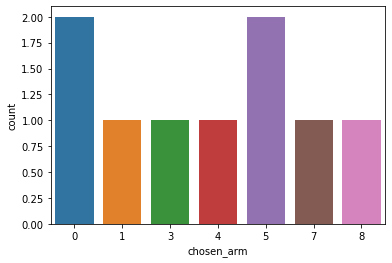

In [17]:
import seaborn as sns
sns.countplot(x="chosen_arm", data=pd.DataFrame(history, columns=["chosen_arm"]))

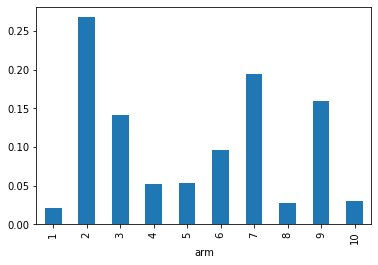

In [18]:
ds.groupby("arm").mean()["reward"].plot(kind="bar")

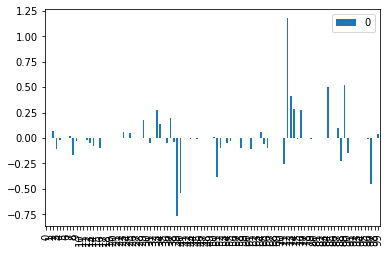

In [19]:
pd.DataFrame(theta, ).plot(kind='bar')

In [20]:
# theta
# pd.DataFrame(theta, ).T.sort_values(0, ascending=False).head()

reward高いアームを選べるように学習できている！

### Thompson Sampling

$X_i(t) = \theta^Ta_{i,t} + \epsilon(t)$

$\epsilon(t) \sim N(., \sigma^2)$

今、$\theta$の事前分布を$\pi(\theta) = N(0, I_d)$ とすると、**各時刻に行動して報酬列を得た際の$\theta$の事後分布は...**

$\displaystyle \pi(\theta| \{i(s), X(s)\}^t_{s=1} )\propto \exp( - \frac{1}{2\sigma^2} (\theta - A_t^{-1}b_t)^TA_t(\theta - A_t^{-1}b_t))$

これは、$\theta$の事後分布が、$N(A^{-1}b, \sigma^2A^{-1})$であることをしている。

#### psuedo code

- input: $\sigma^2$
- param: $\sigma_0^2 > 0$

1. $A^{-1} \leftarrow \frac{\sigma_0^2}{\sigma^2} I_d, b \leftarrow 0_d$
2. **for t=1,2, ... ,T**
3. $\tilde{\theta}$を多変量正規分布$N(A^{-1}b, \sigma^2A^{-1})$から生成
4. $ i \leftarrow argmax_i \tilde{\theta}^T a_{i,t}$を選択して報酬X(t)を観測
5. LinUCBと同じA_inv, b_tの更新
6. **end for**  
\----END CODE\---


- inputの$\sigma^2$をサンプリングのフェーズごとに調整してあげると、適切なリグレットを達成できることが示されている。
    - $\sigma^2 = O(R^2 d logT)$を設定すると、高確率で$O(d^2 \sqrt{T} \log{(dT)})$のリグレットが達成できる。Agrawal and Goyal(2013)

In [21]:
# (sigma**2*A_inv).shape


In [22]:
# np.exp(-np.diag((x - mu)@inv@(x - mu).T)/2.0) / (np.sqrt((2 * np.pi) ** n * det))
from scipy.stats import multivariate_normal


In [23]:
d = 100
sigma=1; sigma_0=1
A_inv =sigma_0/sigma * np.eye(d); A_inv
b_t = np.zeros((d, 1))
alpha = 0.05
n_arms = 10
n_sim = 10
history = []

In [24]:
#  Thompson sampling アルゴリズム
for t in range(1, n_sim):
    # 3. draw_theta
    theta = np.random.multivariate_normal(A_inv@b_t.flatten(), sigma**2*A_inv, size=1)
    # 4. A[t]はa_itの転置ver
    # 各アームの特徴量を引く
    # shape : (10, 1, 100) 10 arms, (1, 100)の特徴量ベクトル
    # 1次元目にアーム１から10までの特徴量を順番に格納している。
    A_ = Arms.draw()
    for i in range(n_arms):
        mu_hat[i] = np.dot(A_[i].ravel(), theta.ravel())
    i_star = mu_hat.argmax(0)[0]
    history.append(i_star)

    #5. スコア最大の行動 i*　を選択して報酬を観測する。
    reward = Arms.get_reward(index=i_star)
    #6.  A-inverse/ bの更新をする。
    second_term = (A_inv@A_[i_star].T@A_[i_star]@A_inv) / (1+A_[i_star]@A_inv@A_[i_star].T)
    A_inv = A_inv - second_term
    b_t += A_[i_star].T*reward    

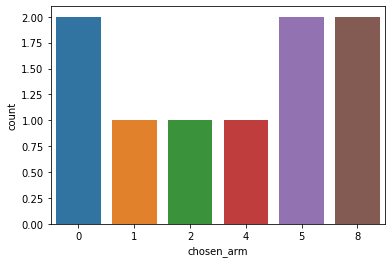

In [25]:
sns.countplot(x="chosen_arm", data=pd.DataFrame(history, columns=["chosen_arm"]))

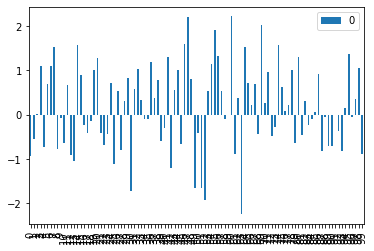

In [26]:
pd.DataFrame(theta, ).T.plot(kind='bar')

In [27]:
pd.DataFrame(theta, ).T.sort_values(0, ascending=False).head()

,0
60,2.218947
47,2.196268
69,2.027035
55,1.908476
46,1.606920


In [28]:
pd.DataFrame(theta, ).T.sort_values(0, ascending=False).tail()

,0
49,-1.650478
51,-1.655617
30,-1.728940
52,-1.920648
63,-2.243914


- LinUCB方策では、$\alpha_t$をtに応じて変化させることで、誤識別率を調整し、リグレット最小化を図るのに対し、Thompson samplingは$\sigma$を動かしている。
- 理論解析においては、やはり頻度論ベースのLinUCB方策に関する研究が進んでいる印象はある。

## Thompson Sampling with Binary Outcome, using Logistic regression

In [29]:
def Hessian(theta, history=None):
    assert previous_cum_matrix is not None
    assert (len(history["actions"]) > 0) & (len(history["arm_features"]) > 0)
    
    prior_part = np.eye(d)/sigma_0
    # self.cum_matrix
    # initial: self.cum_matrix = np.zeros((d, d))
    
    cum_matrix = np.exp(np.dot(theta.ravel(), A_[i_star].ravel()))*A_[i_star].T@A_[i_star]/(1+np.exp(np.dot(theta.ravel(), A_[i_star].ravel())))**2
    
    
    pass
# np.eye(d)/sigma_0 + 


In [30]:
# theta
# arm_feature = A_[1]
# arm_feature.T@arm_feature

In [31]:
@np.vectorize
def component_logit_hessian(theta, arm_feature):
    print(arm_feature, f"{theta}")
    return np.exp(np.dot(theta.ravel(), arm_feature.ravel()))* arm_feature.T@arm_feature /(1+np.exp(np.dot(theta.ravel(), arm_feature.ravel())))**2

In [32]:
# vectorizeで高速化できないか？
# ```np.vectorize()```すると、flattenした状態で並列処理しようとするようである。
component_logit_hessian(theta, A_[:2].astype(np.float64))

8.0 -0.9223503969950761


TypeError: unsupported operand type(s) for @: 'numpy.float64' and 'numpy.float64'

In [33]:
# @np.vectorizeはやめるー
def component_logit_hessian(theta, arm_feature):
#     print((arm_feature.T@arm_feature)[0,0])
#     print(np.exp(np.dot(theta.ravel(), arm_feature.ravel())))
#     print((1+np.exp(np.dot(theta.ravel(), arm_feature.ravel())))**2)
    return np.exp(np.dot(theta.ravel(), arm_feature.ravel()))* arm_feature.T@arm_feature /(1+np.exp(np.dot(theta.ravel(), arm_feature.ravel())))**2

In [34]:
component_logit_hessian(theta, A_[1].astype(np.float64))[0, 0 ]

0.0

In [53]:
def Hessian_inv(theta, Arms=None):
    assert Arms is not None    
    hessian = np.eye(d)/sigma_0
    # self.cum_matrix
    # initial: self.cum_matrix = np.zeros((d, d))
    for i in np.array(Arms.history_idx).flatten():
        x, y = Arms[i]
        hessian = hessian + component_logit_hessian(theta, x.reshape((1, -1)))
    return np.linalg.inv(hessian)

# 以下、scraps

In [ ]:
```

In [ ]:
np.linalg.inv(A_inv)

In [ ]:
contextual.draw()

In [ ]:
class EpsilonGreedyAgent():

    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.V = []

    def policy(self):
        coins = range(len(self.V))
        if random.random() < self.epsilon:
            return random.choice(coins)
        else:
            return np.argmax(self.V)

    def play(self, env):
        # Initialize estimation.
        N = [0] * len(env)
        self.V = [0] * len(env)

        env.reset()
        done = False
        rewards = []
        while not done:
            selected_coin = self.policy()
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards


In [ ]:
def main():
    env = ContextualBandit(n_action=3, max_n_sim=10000, simulation_dataset=(X, y))#CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
    epsilons = [0.0, 0.01, 0.2, 0.5, 0.8]
    game_steps = list(range(10, 310, 10))
    result = {}
    for e in epsilons:
        agent = EpsilonGreedyAgent(epsilon=e)
        means = []
        for s in game_steps:
            env.max_episode_steps = s
            rewards = agent.play(env)
            means.append(np.mean(rewards))
        result["epsilon={}".format(e)] = means
    result["coin toss count"] = game_steps
    result = pd.DataFrame(result)
    result.set_index("coin toss count", drop=True, inplace=True)
    result.plot.line(figsize=(10, 5))
    plt.show()

main()

## 結果
- 全てのarmの探索ができたagentは必ず1を返すarm(virginica)を選択できている。(epsilon=0.0を除く)
- 探索する割合が固定なので、期待値はそれぞれのagentで 1- epsilonの大きさを反映したものなっている。（？）

In [ ]:
import numpy as np

### contextual Banditのagentを作成する。

In [ ]:
pd.DataFrame(contextual.draw())

In [ ]:
# とりあえず作ってみた。
class LinUCB(object):
    def __init__(self, ContextualEnv):
        self.alpha =0.1
        self.sigma = 0.5
        pass
    
    def initialize(self, env):
        self.d = env.n_features
        self.inv_A = np.eye(self.d)
        self.b = np.zeros((self.d,1))

    def policy(self, env):
        # get action
        theta = self.inv_A@self.b
        # calculate UCBscore
        alpha = self.alpha * np.sqrt(np.log1p(env.t_count))
        a_t = pd.DataFrame(env.draw()).values.T # n_features * n_actions
        UCBscore = a_t@theta + np.diag(self.alpha*self.sigma*np.sqrt(a_t@self.inv_A@a_t.T)).reshape((-1, 1))
        print(UCBscore)
        action = np.argmax(UCBscore)
        print(action)   
        chosen_features = a_t.loc[:, action].values
        return action , chosen_features
    def update(self, features, reward):
        # woodbury's identity
        self.inv_A += (inv_A@features@features.T@inv_A)/(1 + features.T@inv_A@features)
        self.b = self.b + features*reward
        
    def play(self, env):
        # Initialize estimation.
        rewards = []
        # while not done:
        self.initialize()
        env.reset()
        action, features = self.policy(env)
        reward, done = env.step(action) 
        self.update(features, reward)
        rewards.append(reward)
        return rewards
    

In [ ]:
agent = LinUCB()
agent.initialize(contextual)

In [ ]:
agent.__dict__
self = agent

In [ ]:
# a_it ベクトルを生成するコード
a_t = pd.DataFrame(contextual.draw()).values.T # n_features * n_actions
# a_t (#actions * #features)

In [ ]:
# stab
theta = np.ones((4, 1))
UCBscore = a_t@theta;print(UCBscore)
action = np.argmax(UCBscore)
action

In [ ]:
np.diag(np.eye(4))

In [ ]:
X

In [ ]:

random.sample(y[y==1].tolist(), k=1)

In [ ]:
n_sim

In [ ]:
# Import personalization data-set
 
# Info: https://d1ie9wlkzugsxr.cloudfront.net/data_irecsys_CARSKit/Movie_DePaulMovie/README.txt
 
data_url = "http://d1ie9wlkzugsxr.cloudfront.net/data_irecsys_CARSKit/Movie_DePaulMovie/ratings.csv" 

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv("ratings.csv")

In [ ]:
df.head()

In [ ]:
print(df.isna().sum(axis=0));df.userid.value_counts().plot(kind="box")

In [ ]:
for col in ["Time", "Location", "Companion"]:
    print(df[col].value_counts())

# Linear Bandit Algorithm

- 他のマシンに関する情報を一切持たないケースを考えていたが、例えば、マシンごとの特徴量（*）から類似するマシンの報酬を推定する事ができるケースが現実問題で多々ある。

(*):筆者はやった事ないが、パチンコの台の傾きや、釘と釘の長さによって、当たりやすいかいなかが変わってくるらしい。

In [ ]:
# https://github.com/icoxfog417/baby-steps-of-rl-ja/blob/master/EL/epsilon_greedy.py
class CoinToss():

    def __init__(self, head_probs, max_episode_steps=30):
        self.head_probs = head_probs
        self.max_episode_steps = max_episode_steps
        self.toss_count = 0

    def __len__(self):
        return len(self.head_probs)

    def reset(self):
        self.toss_count = 0

    def step(self, action):
        final = self.max_episode_steps - 1
        if self.toss_count > final:
            raise Exception("The step count exceeded maximum. \
                            Please reset env.")
        else:
            done = True if self.toss_count == final else False

        if action >= len(self.head_probs):
            raise Exception("The No.{} coin doesn't exist.".format(action))
        else:
            head_prob = self.head_probs[action]
            if random.random() < head_prob:
                reward = 1.0
            else:
                reward = 0.0
            self.toss_count += 1
            return reward, done
        
class EpsilonGreedyAgent():

    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.V = []

    def policy(self):
        coins = range(len(self.V))
        if random.random() < self.epsilon:
            return random.choice(coins)
        else:
            return np.argmax(self.V)

    def play(self, env):
        # Initialize estimation.
        N = [0] * len(env)
        self.V = [0] * len(env)

        env.reset()
        done = False
        rewards = []
        while not done:
            selected_coin = self.policy()
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards



In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

def main():
    env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
    epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]
    game_steps = list(range(10, 310, 10))
    result = {}
    for e in epsilons:
        agent = EpsilonGreedyAgent(epsilon=e)
        means = []
        for s in game_steps:
            env.max_episode_steps = s
            rewards = agent.play(env)
            means.append(np.mean(rewards))
        result["epsilon={}".format(e)] = means
    result["coin toss count"] = game_steps
    result = pd.DataFrame(result)
    result.set_index("coin toss count", drop=True, inplace=True)
    result.plot.line(figsize=(10, 5))
    plt.show()

main()

# Construct Agents

# LinUBC

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# get_dummies, non idempotent processing
# df = pd.concat([df, pd.get_dummies(df[["Time", "Location", "Companion"]])], axis=1)

In [ ]:
# dummies = pd.get_dummies(df[["Time", "Location", "Companion"]])

# Get Interactions

In [ ]:
pe = PolynomialFeatures(2, interaction_only=True)

interactions = pe.fit_transform(dummies, )

generated_columns = pe.get_feature_names()

assert  all(dummies.iloc[:, 1] == interactions[:, 2])

corresp_cols ={f"x{i}": col for i , col in enumerate(dummies.columns)}

# generated_columns 
for k,v in corresp_cols.items():
    generated_columns = [col.replace(k, v) for col in generated_columns]
generated_columns

In [ ]:
dummies

In [ ]:
# features of all arms
non_features_cols = ["userid", "itemid", "rating"]
df.columns.difference(non_features_cols).to_list()

In [ ]:
# rewards vector
rewards = df.rating.values.astype(np.float)
features = dummies.values
f_names = dummies.columns.to_list()

In [ ]:
rewards

In [ ]:
# t:time (各ユーザごとにpartitionきる？)
d = features.shape[1]

In [ ]:
A_a = np.eye(d)
b_a = np.zeros((d, 1))

In [ ]:
alpha = 0.3

In [ ]:
theta_a = np.linalg.inv(A_a)@b_a
p_ta = features@theta_a + alpha*np.sqrt(np.diag(features@np.linalg.inv(A_a)@features.T).reshape((-1, 1)))

In [ ]:
(features@theta_a).shape

In [ ]:
p_ta.shape

# サンプルデータが見つからない...!

- どうしようーってなっていたやさき、そういえばバンディットって「自分が選択したあーむ以外の報酬が見れないだけで問題設定はマルチラベリング問題のオンライン学習と同義」、と本多さんの本に書いてあったことを思い出した。
    https://github.com/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb
- irisを活用する！

In [ ]:
from sklearn.datasets import load_iris 

In [ ]:
# X, y = load_iris(True)

In [ ]:
X, y = load_iris(return_X_y=True)

In [ ]:
y

In [ ]:
# irisデータからbaditの文脈に合うようにsamplingできるクラスを作成する。
df_cps1 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
df_cps3 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
df_nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

In [ ]:
df_cps1.describe()

In [ ]:
# df_cps3.describe()
df_nsw.columns
regressors_columns =  ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree',]
target_column = 're78'
X = df_nsw[regressors_columns].values
y = df_nsw[target_column].values